# Capstone Project Pneumonia Image Recognition with CNN and tensorflow

# Problem Statement
How can images of infant chest X Rays be viewed algorithmicly such that Pneumonia can be detected from Normal conditions with a high level of confidence?

A Deep Learning algorithm of Convolution Neural Networks will be applied to images of pediatric X Rays separated into Pneumonia and Normal groups to determine if images can predict results based on training a model on the dataset

Images from the Kaggle Dataset: Pediatric Phneumonia Chest X-ray
https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray

Code references from Towards Data Science: https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Dataset by Daniel Kermany and Michael Goldbaum in 2018.  The data includes 5,856 images labelled as either pneumonia or normal 

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/rscbjbr9sj.2

In [1]:
# typical imports
import os
import random
import shutil
import sys

import matplotlib.pyplot as plt  # To visualize data
import numpy as np               # For arrays
import pandas as pd              # For holding and handling data

# image processing imports
import cv2                       # For image to file handling
import glob                      # to read all files in directory

# for preprocessing the images
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# for reading images from folders
from tensorflow.keras.preprocessing.image import DirectoryIterator  

# determines class weights as array of class weight vectors
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define Overall Structure for modeling
# Directories for train, test, and validation datasets
train_path = 'CS_Pneumonia/dataset/train'
test_path = 'CS_Pneumonia/dataset/test'
valid_path = 'CS_Pneumonia/dataset/valid'

# Batch size is number of trainging examples per iteration
batch_size = 20

# Dimension size of images set as 400x400 to limit loading on machine
img_height = 500
img_width = 500

In [3]:
# method to move files randomly between source and dest directories 
# given percentage of files to move
def move_pics(s,d,percent):
    file_list = [f for f in os.listdir(s) if os.path.isfile(os.path.join(s, f))]
    num_files_to_move = int(len(file_list)*percent)
    
    
    for i in range(num_files_to_move):
        random_file = random.choice(os.listdir(s))
        source_file = s+'/'+random_file
        shutil.move(source_file,d)
    print('Files moved:',num_files_to_move,'from',s,'to',d)

In [4]:
# Make a VALID directory of images 
# Create Valid directory of files by pulling 20% from train directory
# pull 10% from both PNEUMONIA and NORMAL folders

# The following 2 lines were executed once to move files, then commented out
#move_pics(train_path+'/PNEUMONIA',valid_path+'/PNEUMONIA',0.1)
#move_pics(train_path+'/NORMAL',valid_path+'/NORMAL',0.1)

In [5]:
# Read in the separate files of images, separated by separate folders for test/train
# within TEST/TRAIN separated by folders for PNEUMONIA and NORMAL
# glob function recursively opens all files in folder
path_train_pneumonia = glob.glob("Capstone_train/PNEUMONIA/*.jpeg")
path_train_normal = glob.glob("Capstone_train/NORMAL/*.jpeg")
path_test_pneumonia = glob.glob("Capstone_test/PNEUMONIA/*.jpeg")
path_test_normal = glob.glob("Capstone_test/NORMAL/*.jpeg")
categories = ['PNEUMONIA', 'NORMAL']
folders = ['train', 'test', 'valid']

In [6]:
# read all files using glob method and record their features in DataFrame
file_list = []
for f in folders:
    for c in categories:
        for n in glob.glob('CS_Pneumonia/dataset/'+f+'/'+c+'/*.jpeg'):
            img = cv2.imread(n)
            # cv2.shape provides information for each image as 
            #height, width, number of channels of image
            width = img.shape[1]      # width
            height = img.shape[0]      # height
            channel = img.shape[2]
            ratio = height/width
            file_name = os.path.basename(n)
            info = [file_name,f,c,width,height,channel, ratio]
            file_list.append(info)
                
print(len(file_list))
df_pics = pd.DataFrame(file_list)
df_pics.columns = ['File','Data Set','Result','Width','Height','Channels','Ratio']
df_pics.describe

5856


<bound method NDFrame.describe of                                File Data Set     Result  Width  Height  \
0        person63_bacteria_306.jpeg    train  PNEUMONIA   1048     736   
1     person1438_bacteria_3721.jpeg    train  PNEUMONIA    984     672   
2      person755_bacteria_2659.jpeg    train  PNEUMONIA    992     712   
3          person478_virus_975.jpeg    train  PNEUMONIA   1224     888   
4      person661_bacteria_2553.jpeg    train  PNEUMONIA    864     480   
...                             ...      ...        ...    ...     ...   
5851      NORMAL2-IM-0616-0001.jpeg    valid     NORMAL   1456    1279   
5852      NORMAL2-IM-0572-0001.jpeg    valid     NORMAL   1750    1526   
5853      NORMAL2-IM-0848-0001.jpeg    valid     NORMAL   1514    1032   
5854      NORMAL2-IM-1157-0001.jpeg    valid     NORMAL   1306     994   
5855              IM-0656-0001.jpeg    valid     NORMAL   1504    1395   

      Channels     Ratio  
0            3  0.702290  
1            3  0.68292

In [7]:
# Verify the characteristic features only have 2 values, and show channels for color
print("Data Set",df_pics['Data Set'].unique())
print("Test(1) or Train(0) Data",df_pics['Result'].unique())
print("Channels",df_pics['Channels'].unique())

Data Set ['train' 'test' 'valid']
Test(1) or Train(0) Data ['PNEUMONIA' 'NORMAL']
Channels [3]


In [8]:
# Determine the typical ratio of Height/Width for the dataset
df_pics['Ratio'].describe()

count    5856.000000
mean        0.712905
std         0.117312
min         0.295964
25%         0.630616
50%         0.706272
75%         0.792627
max         1.197044
Name: Ratio, dtype: float64

From the 5856 pictures provided (both test, train, and valid) the typical ratio is 0.73 (Height/Width), However we need to look at the range of file sizes to determine if they can all be used.  We also see that all images use 3 color channels so they must be converted to grayscale which is 1 color channel.

In [9]:
df_pics.head()

,File,Data Set,Result,Width,Height,Channels,Ratio
0,person63_bacteria_306.jpeg,train,PNEUMONIA,1048,736,3,0.702290
1,person1438_bacteria_3721.jpeg,train,PNEUMONIA,984,672,3,0.682927
2,person755_bacteria_2659.jpeg,train,PNEUMONIA,992,712,3,0.717742
3,person478_virus_975.jpeg,train,PNEUMONIA,1224,888,3,0.725490
4,person661_bacteria_2553.jpeg,train,PNEUMONIA,864,480,3,0.555556


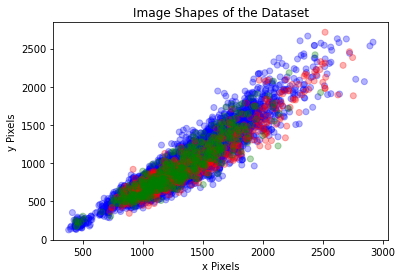

In [10]:
# Scatterplot of Width and Height parameters to show sizing
colors = df_pics['Data Set'].map({'train':'b', 'test':'r', 'valid':'g'})
fig, ax = plt.subplots()
ax.scatter(df_pics['Width'],df_pics['Height'],c=colors, alpha=0.3)
ax.set_xlabel("x Pixels")
ax.set_ylabel("y Pixels")
ax.set_title("Image Shapes of the Dataset")
plt.show()

The scatter plot reveals that the images are split between train(blue), test(red), and valid(green) data sets.  The distribution of sizes appears common between these splits

# Data Wrangling

In [19]:
# IMAGE Wrangline
# Use image data generator from keras for Training Set
train_image_gen = ImageDataGenerator(rescale = 1./255, 
                               shear_range = 0.2, 
                               zoom_range = 0.2, 
                               horizontal_flip = True)
# Use image data generator from keras for Test Set
test_image_gen = ImageDataGenerator(rescale = 1./255)
valid_image_gen = ImageDataGenerator(rescale = 1./255)

# rescale: scales array of pixel balues between [0,1]
# shear_range: shape of image transformed by fixing one axis and stretching other
# zoom_range: make image smaller if zoom <1
# horizontal_flip: Randomly flips some images horizontally

In [20]:
# IMAGE LOADING - read files from folders
# Load Training Data
train = train_image_gen.flow_from_directory(train_path, 
                                target_size=(img_height,img_width),
                                color_mode='grayscale',
                                class_mode='binary',
                                batch_size=batch_size)
# Load Testing Data
test = test_image_gen.flow_from_directory(test_path, 
                                target_size=(img_height,img_width),
                                color_mode='grayscale',
                                class_mode='binary',
                                batch_size=batch_size)

# Load Validating Data
test = valid_image_gen.flow_from_directory(valid_path, 
                                target_size=(img_height,img_width),
                                color_mode='grayscale',
                                class_mode='binary',
                                batch_size=batch_size)
# target_size: resizes input image to pixel dimensions heightxwidth
# color_mode: if set to 'grayscale' set to 1 color channel for BW
# batch_size: sets number of images for each batch for the generator
#.    set to 20 to not overrun RAM space
# class_mode: 'binary' because we only have 2 output classes to predict
#.  pneumonia and normal

Found 4710 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 522 images belonging to 2 classes.


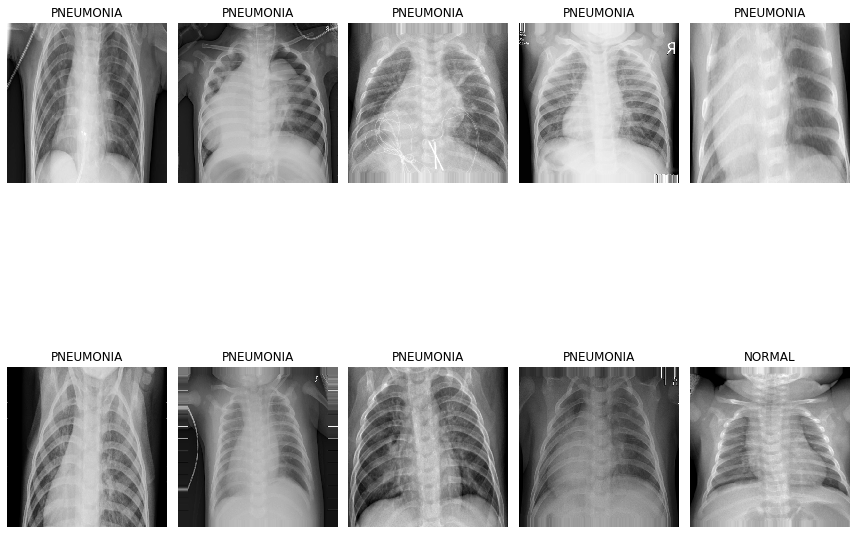

In [21]:
# View images
# Display batch of images to see results of import
plt.figure(figsize=(12,12))
for i in range(0,10):
    plt.subplot(2,5,i+1)
    for im, title in train:
        image = im[0]
        dic = {0:'NORMAL',1:'PNEUMONIA'}
        plt.title(dic.get(title[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray', interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# CNN Model Build
Convolutional layers: (input data image with 2D convolutional layers) Creates feature map. Depth of filter same as depth of input- grayscale is 1.  Will apply a Sequential model to allow us to build layer by layer

Determining the dimension of activation maps:
(N + 2P — F)/ S + 1; where N = Dimension of image (input) file
P = Padding
F = Dimension of filter
S = Stride

ReLu layers: (Rectified Linear Unit - linear function to output directly if positive, otherwise zero) Increases non-linearity. _Better than Sigmoid and Tanh based on overcoming the vanishing gradient problem.

Pooling layers: Combine to create spatial variance, make objects detectable no matter where they are located in the image

Flattening: make long vector of pooled features

Fully connect layer: Input vector into neural network.  Process features through the network.  The fully connected layers votes on the classes

Train the model: using forward propagation and backpropagation, trains the neural network with weights and feature detectors


In [14]:
# Create the model
model = Sequential()

# Add model layers
model.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))
# number of nodes in each layer - 32
# activation - relu model for rectified linear
# input_shape - pizel size of image
# pool_size - reduce feature map by factor of 2, typically (2,2)

# Add another model layer to further reduce shape
model.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))

# Add another model layer to further reduce shape
model.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))
          
model.add(Conv2D(32, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))
          
model.add(Conv2D(64, (3,3),
                activation='relu',
                input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))

# Now flatten the layers
model.add(Flatten())

# Use Dense to lower shape down to 1 output
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'relu', units = 32))
model.add(Dense(activation = 'relu', units = 1))


In [15]:
# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#   optimizer controls the learning rate: 
#.    "Adam" good general use-adjusts lerning rate throughout training
#   loss function: binary_crossentropy, for binary (2 choice) problems
#   metrics: accuracy

In [16]:
# Look at model summary to determine layer sizes
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 32)        9

In [17]:
# plot the model design
plot_model(model,show_shapes=True, 
           show_layer_names=True, 
           rankdir='TB',
          expand_nested=True)

# rankdir: 'TB' is a vertical plot
# expand_nested: to expand nested models into clusters

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Fit Model

In [18]:
# Set a validation set of data to set early stopping point for model fit
early_stopping = EarlyStopping(monitor='val_loss',patience = 3)

# hyperparameter to set how much to change model in response to error rate
# ReduceLROnPLateau: tool to adjust when plateau detected
# factor: multiplier of learning rate
# patience: How many training epochs to wait before triggering change
lrr = ReduceLROnPlateau(monitor='val_loss',patience = 3, factor=0.2)
callback_list = [early_stopping, learning_rate_reduction]

# look at class weights
class_weights = compute_class_weight('balanced',
                                     np.unique(train.classes),
                                     train.classes)
cw = dict(zip(np.unique(train.classes),class_weights))

# fit the model
model.fit(train,epochs=25,validation_split=0.2, callbacks=[early_stopping], class_weight=cs, )

NameError: name 'learning_rate_reduction' is not defined